# Importing Libraries

In [1]:
import os
import cv2
import torch
import math
import random
import platform
import numpy as np
import torchvision
import albumentations as A
import matplotlib.pyplot as plt
import torch.nn.functional as F

from model import U2NET
from pathlib import Path
from natsort import natsorted
# from tqdm.notebook import tqdm
from tqdm import tqdm
from PIL import Image, ImageOps
from torch.autograd import Variable
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1.9.1
True
0
1
NVIDIA GeForce RTX 2060 SUPER


# Global Variables

## Data Paths

In [3]:
X_DIR = "C:/Users/RAJDEEP/Downloads/archive/images"
Y_DIR = "C:/Users/RAJDEEP/Downloads/archive/annotations"

X_TRAIN_DIR = os.path.join(X_DIR, "train")
Y_TRAIN_DIR = os.path.join(Y_DIR, "train")

X_VALID_DIR = os.path.join(X_DIR, "val")
Y_VALID_DIR = os.path.join(Y_DIR, "val")

## Device

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Model

In [5]:
PRETRAINED_MODEL_PATH = "./saved_models/u2net/u2net.pth"

In [6]:
CHECKPOINT_DIR = "./model_checkpoints"

In [7]:
TRAIN_BS = 8
VALID_BS = 1

In [8]:
INPUT_SZ = (320, 320)
#INPUT_SZ = (720, 720)

# Visualize

In [9]:
def denormalize_img(img):    
    img[:,:,0] = (img[:,:,0] * 0.229) + 0.485
    img[:,:,1] = (img[:,:,1] * 0.224) + 0.456
    img[:,:,2] = (img[:,:,2] * 0.225) + 0.406
    
    img = img * 255
    img = img.astype('uint8') 
    return img

def denormalize_mask(mask):    
    mask = (mask / np.max(mask)) * 255.
    return mask

In [10]:
def visualize(img_T, mask_T):
    fig = plt.figure(figsize=(20,20))
    
    img_arr = img_T.cpu().data.numpy()
    mask_arr = mask_T.cpu().data.numpy()
    
    img_arr = img_arr.transpose((1,2,0))
    mask_arr = mask_arr.transpose((1,2,0))
    
    img_arr = denormalize_img(img_arr)
    mask_arr = denormalize_mask(mask_arr)
    
    mask_arr = np.squeeze(mask_arr)
    
    mask = Image.fromarray(mask_arr).convert("L")
    
    overlay = Image.fromarray(img_arr).convert("RGB")
    overlay.putalpha(mask)
    overlay_arr = np.array(overlay)

    plt.subplot(1, 3, 1)
    plt.title("Input")
    plt.imshow(img_arr)
    
    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask_arr)
    
    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay_arr)

# Preprocessing Functions

In [11]:
def resize_to_inputsz(x, **kwargs):
    
    # For RGB images with 3 channels:
    if x.shape[-1] == 3:        
        y = Image.fromarray(x)
        y = y.resize(INPUT_SZ, resample = Image.LANCZOS)
        y = np.array(y)
        
    #For Masks with 1 channel:
    if x.shape[-1] == 1:
        x = x.squeeze()
        y = Image.fromarray(x)
        y = y.resize(INPUT_SZ, resample = Image.LANCZOS)
        y = np.array(y)
        y = np.expand_dims(y, -1)
            
    return y

In [12]:
def scale_0_1(x, **kwargs):
    return x / 255.

In [13]:
def augment_normalize(doAugment = True, doNormalize = True, doTensored = True):
    transform = []
    
    if doAugment:
        doCropTransform = True
        doGeometricTransform = True
        doVisualTransform = True       
        
        if doCropTransform:
            transform.extend([
                A.CropAndPad(percent = (-0.02,-0.2), keep_size = False, 
                             sample_independently = True, p = 0.5),
            ])
            
        if doGeometricTransform:
            transform.extend([
                A.HorizontalFlip(p = 0.5)
            ])
        
        if doVisualTransform:
            transform.extend([                
                A.OneOf([
                    A.ChannelShuffle(p = 0.2),
                    A.RGBShift(p = 0.4),
                    A.HueSaturationValue(p = 0.4),                    
                ], p = 0.3),
                
                A.OneOf([
                    A.ColorJitter(p = 0.2),
                    A.CLAHE(p = 0.3),
                    A.RandomBrightnessContrast(p = 0.3),
                    A.RandomGamma(p = 0.2),
                ], p = 0.3),
                
                A.OneOf([
                    A.GaussNoise(p = 0.5),
                    A.ISONoise(p = 0.5),
                    
                ], p = 0.2),

                A.OneOf([
                    #A.AdvancedBlur(p = 0.1),
                    A.Blur(p = 0.1),
                    A.GaussianBlur(p = 0.3),
                    A.GlassBlur(p = 0.1),
                    A.MedianBlur(p = 0.3),
                    A.MotionBlur(p = 0.2),      
                ], p = 0.2),
            
                #A.PixelDropout(p = 0.1),  
            ])
            
    transform.extend([
        A.Lambda(image = resize_to_inputsz, mask = resize_to_inputsz, p = 1.0),
        A.Lambda(mask = scale_0_1, p = 1.0),            
    ])


    if doNormalize:
        transform.append(A.Normalize(mean = [0.485, 0.456, 0.406],
                                     std = [0.229, 0.224, 0.225],
                                     p = 1.0)
        )

        
    if doTensored:
        transform.append(ToTensorV2(p = 1.0, transpose_mask = True))
        
    return A.Compose(transform)

# DataSet

In [14]:
class CustomDataset(Dataset):
    def __init__(self, images_dir, masks_dir, preprocessing = None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.preprocessing = preprocessing
        
        self.image_ids = natsorted(os.listdir(self.images_dir))
        self.n_imgs = len(self.image_ids)
        print("Number of Images found: ", self.n_imgs)
        
    def __getitem__(self, i):
        image_id = self.image_ids[i]
        name = "".join(image_id.split(".")[:-1])
        
        image_path = os.path.join(self.images_dir, image_id)
        mask_path = os.path.join(self.masks_dir, name + ".png")
        
        
        image = Image.open(image_path).convert("RGB")
        #image = ImageOps.exif_transpose(image)
        
        mask = Image.open(mask_path).convert("L")
        assert (image.size == mask.size)
        
        image_arr = np.array(image)     
        
        mask_arr = np.array(mask)
        mask_arr[mask_arr > 0] = 255
        mask_arr = np.expand_dims(mask_arr, -1)
        
        image_T, mask_T = None, None 
        if self.preprocessing:
            sample = self.preprocessing(image = image_arr, mask = mask_arr)
            image_T, mask_T = sample['image'], sample['mask']

        return image_T, mask_T

    def __len__(self):
        return self.n_imgs

In [15]:
train_dataset = CustomDataset(X_TRAIN_DIR, 
                              Y_TRAIN_DIR, 
                              preprocessing = augment_normalize(doAugment = True, 
                                                                doNormalize = True,
                                                                doTensored = True))
val_dataset = CustomDataset(X_VALID_DIR, 
                            Y_VALID_DIR, 
                            preprocessing = augment_normalize(doAugment = False, 
                                                              doNormalize = True,
                                                              doTensored = True))

Number of Images found:  14000
Number of Images found:  2000


# DataLoaders

In [16]:
train_loader = DataLoader(train_dataset, 
                          batch_size = TRAIN_BS, 
                          shuffle = True, 
                          num_workers = 0, 
                          pin_memory = True)

val_loader = DataLoader(val_dataset, 
                        batch_size = VALID_BS, 
                        shuffle = False, 
                        num_workers = 0, 
                        pin_memory = True)

## Visualize the Train Data

Image Batch Shape and Type:  torch.Size([8, 3, 320, 320]) torch.float32
Image Batch Range:  tensor(2.6400) tensor(-2.1179)
Mask Batch Shape and Type:  torch.Size([8, 1, 320, 320]) torch.float64
Mask Batch Range:  tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64)


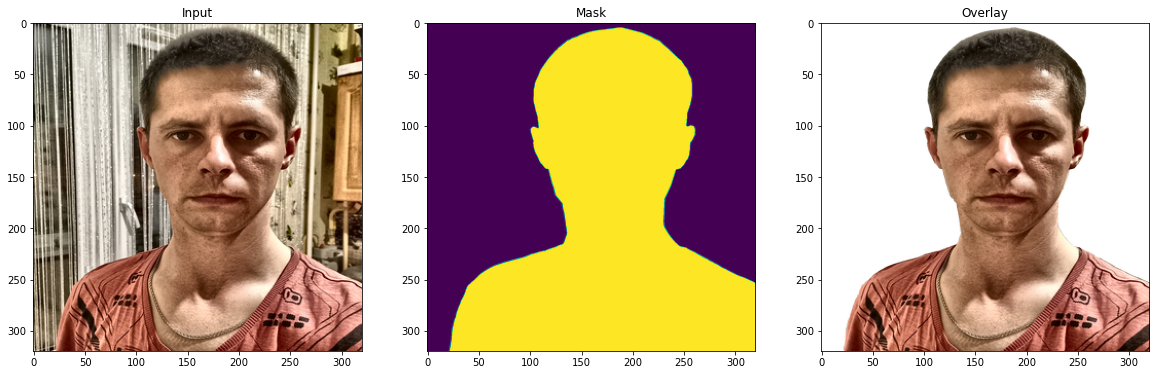

In [17]:
img_batch, mask_batch = next(iter(train_loader))

print("Image Batch Shape and Type: ", img_batch.shape, img_batch.dtype)
print("Image Batch Range: ", img_batch.max(), img_batch.min())

print("Mask Batch Shape and Type: ", mask_batch.shape, mask_batch.dtype)
print("Mask Batch Range: ", mask_batch.max(), mask_batch.min())

visualize(img_batch[0], mask_batch[0])

In [18]:
torch.unique(mask_batch[0], return_counts = True)

(tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
         0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
         0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020,
         0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373,
         0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725,
         0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
         0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
         0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2824,
         0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137, 0.3176,
         0.3255, 0.3294, 0.3333, 0.3373, 0.3412, 0.3451, 0.3490, 0.3529, 0.3569,
         0.3608, 0.3647, 0.3686, 0.3725, 0.3765, 0.3804, 0.3882, 0.3922, 0.3961,
         0.4039, 0.4078, 0.4118, 0.4157, 0.4196, 0.4235, 0.4275, 0.4314, 0.4353,
         0.4392, 0.4431, 0.4

## Visualize the Validation Data

Image Batch Shape and Type:  torch.Size([1, 3, 320, 320]) torch.float32
Image Batch Range:  tensor(2.2566) tensor(-2.1179)
Mask Batch Shape and Type:  torch.Size([1, 1, 320, 320]) torch.float64
Mask Batch Range:  tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64)


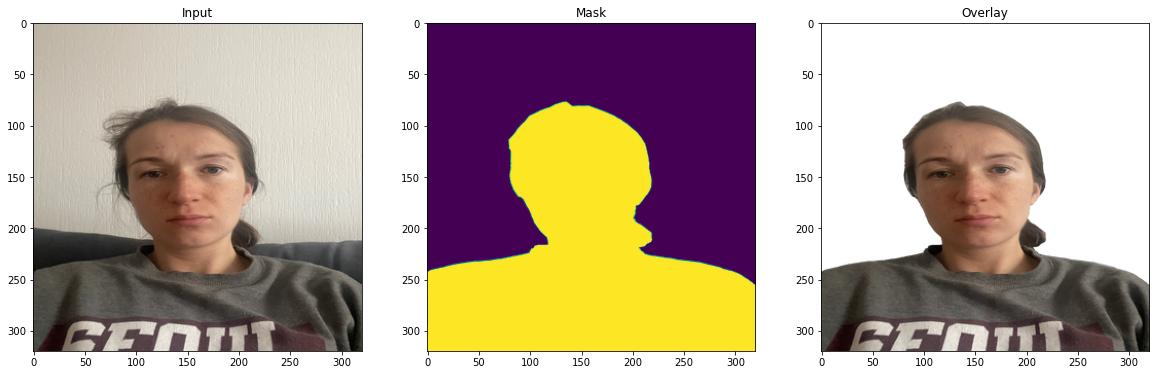

In [19]:
img_batch, mask_batch = next(iter(val_loader))

print("Image Batch Shape and Type: ", img_batch.shape, img_batch.dtype)
print("Image Batch Range: ", img_batch.max(), img_batch.min())

print("Mask Batch Shape and Type: ", mask_batch.shape, mask_batch.dtype)
print("Mask Batch Range: ", mask_batch.max(), mask_batch.min())

visualize(img_batch[0], mask_batch[0])

# Loss Function

In [20]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps = 1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss
    
rmse_loss = RMSELoss()

In [21]:
def create_edge_masks(mattes, width = 7):
    edge_masks = []
    mattes = mattes.cpu().data.numpy()
    kernel = np.ones((width, width),np.uint8)    
    
    for matte in mattes:
        edge_mask = cv2.morphologyEx(matte[0], cv2.MORPH_GRADIENT, kernel)        
        edge_masks.append(np.expand_dims(edge_mask,0))
        
    edge_masks = np.array(edge_masks).astype('bool')
    edge_masks = torch.tensor(edge_masks).to(DEVICE)
    return edge_masks

In [22]:
def custom_boundary_based_loss(outputs, targets, edge_loss_wt = 4.0, includeBoundaryLoss = False):
    
    if includeBoundaryLoss:
        edge_masks = create_edge_masks(targets)
    
    total_loss = 0
    for outs in outputs:
        if includeBoundaryLoss:
            outs_edge = outs * edge_masks
            targets_edge = targets * edge_masks            
            edge_loss = rmse_loss(outs_edge, targets_edge)
        else:
            edge_loss = 0
        
        semantic_loss = rmse_loss(outs, targets)
        total_loss += (semantic_loss + edge_loss_wt * edge_loss)

    total_loss /= len(outputs)
    return total_loss

# U2 Net

In [23]:
model = U2NET(3, 1)
model.load_state_dict(torch.load(PRETRAINED_MODEL_PATH))

model

U2NET(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(32, 32, k

# Params

In [24]:
start_epoch = 0
n_epochs = 15

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = learning_rate, 
                                                steps_per_epoch = len(train_loader), 
                                                epochs = n_epochs)

loss_fn = custom_boundary_based_loss
save_freq = 3
beta = 0.9
use_weighted_loss_train = True

use_amp = False
scaler = torch.cuda.amp.GradScaler(enabled = use_amp)

moving_loss = {'train': 0, 'valid': 0}
loss_values = {"train": [], "valid": []}

# Load Checkpoint if any

In [25]:
if os.path.exists(CHECKPOINT_DIR) and os.listdir(CHECKPOINT_DIR):
    
    latest_ckpt = natsorted(os.listdir(CHECKPOINT_DIR))[-1]
    checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, latest_ckpt), map_location = DEVICE)  

    start_epoch = checkpoint['epoch']
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(DEVICE)
    
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    print("Loaded checkpoint: ", latest_ckpt)

In [26]:
model.to(DEVICE)

U2NET(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(32, 32, k

# Training

In [27]:
def train(train_loader, model, criterion, optimizer, scheduler, epoch, beta, use_weighted_loss_train):
    model.train()
    stream = tqdm(train_loader)
    
    for i, (images, targets) in enumerate(stream, start=1):        
        images = images.to(DEVICE, non_blocking = True, dtype = torch.float)
        targets = targets.to(DEVICE, non_blocking = True, dtype = torch.float)
        
        #optimizer.zero_grad(set_to_none = True)
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast(enabled = use_amp):
            outputs = model(images)  
            loss = criterion(outputs, targets, includeBoundaryLoss = use_weighted_loss_train)
     
        if moving_loss['train']:
            moving_loss['train'] = beta * moving_loss['train'] + (1-beta) * loss.item()
        else:
            moving_loss['train'] = loss.item()
            
        loss_values['train'].append(moving_loss['train'])
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scale = scaler.get_scale()
        scaler.update()
        skip_lr_sched = (scale > scaler.get_scale())
        
        if not skip_lr_sched:
            scheduler.step()      

        stream.set_description(
            "Epoch: {epoch}.  --Train--  Loss: {m_loss:04f}".format(epoch = epoch, m_loss = moving_loss['train'])
        )

In [28]:
def validate(val_loader, model, criterion, epoch, beta):
    model.eval()
    stream = tqdm(val_loader)
    
    with torch.no_grad():
        for i, (images, targets) in enumerate(stream, start=1):
            images = images.to(DEVICE, non_blocking=True, dtype = torch.float)
            targets = targets.to(DEVICE, non_blocking=True, dtype = torch.float)
            
            with torch.cuda.amp.autocast(enabled = use_amp):
                outputs = model(images)            
                loss = criterion(outputs, targets)

            if moving_loss['valid']:
                moving_loss['valid'] = beta * moving_loss['valid'] + (1-beta) * loss.item()
            else:
                moving_loss['valid'] = loss.item()
            
            loss_values['valid'].append(moving_loss['valid'])
            stream.set_description(
                "Epoch: {epoch}.  --Valid--  Loss: {m_loss:04f}".format(epoch = epoch, m_loss = moving_loss['valid'])
            )

In [29]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, start_epoch, 
                       n_epochs, ckpt_dir, save_freq, beta, use_weighted_loss_train):    
    os.makedirs(ckpt_dir, exist_ok = True)
    
    for epoch in range(start_epoch + 1, start_epoch + n_epochs + 1):        
        train(train_loader, model, criterion, optimizer, scheduler, epoch, beta, use_weighted_loss_train)
        validate(val_loader, model, criterion, epoch, beta)
        
        ckpt_path = os.path.join(ckpt_dir, "{epoch}.pth".format(epoch = epoch))
        
        if epoch % save_freq == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                }, ckpt_path)
        
    return model

In [30]:
model = train_and_validate(model, 
                           train_loader, 
                           val_loader,
                           criterion = loss_fn,
                           optimizer = optimizer,
                           scheduler = scheduler,
                           start_epoch = start_epoch,
                           n_epochs = n_epochs,                           
                           ckpt_dir = CHECKPOINT_DIR,
                           save_freq = save_freq,
                           beta = beta,
                           use_weighted_loss_train = use_weighted_loss_train)

  0%|                                                                                         | 0/1750 [00:00<?, ?it/s]C:\Users\RAJDEEP\miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\RAJDEEP\miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
C:\Users\RAJDEEP\miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch: 15.  --Valid--  Loss: 0.

# Plot Loss Curves

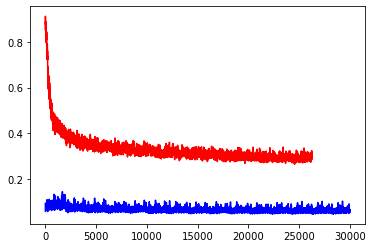

In [31]:
plt.plot(loss_values['train'], 'r')
plt.plot(loss_values['valid'], 'b')

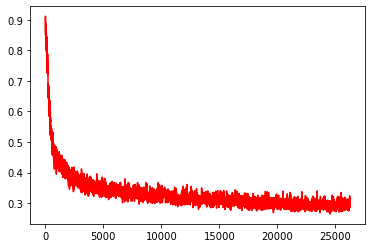

In [32]:
plt.plot(loss_values['train'], 'r')

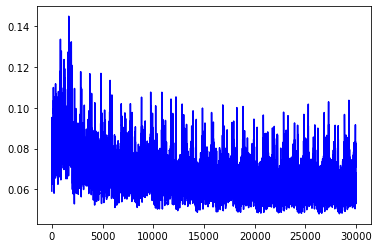

In [33]:
plt.plot(loss_values['valid'], 'b')

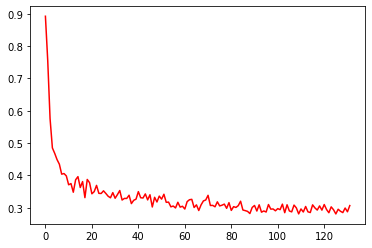

In [44]:
loss_vals_train = []
for i,v in enumerate(loss_values['train']):
    if i % 200 == 0:
        loss_vals_train.append(v)
    
plt.plot(loss_vals_train, 'r')

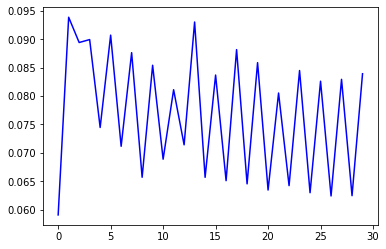

In [48]:
loss_vals_train = []
for i,v in enumerate(loss_values['valid']):
    if i % 1000 == 0:
        loss_vals_train.append(v)
    
plt.plot(loss_vals_train, 'b')

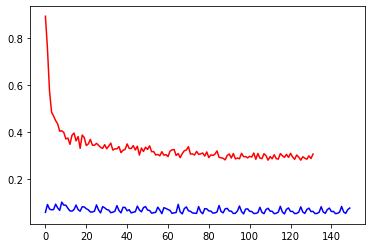

In [58]:
loss_vals_train = []
for i,v in enumerate(loss_values['train']):
    if i % 200 == 0:
        loss_vals_train.append(v)
        
loss_vals_valid = []
for i,v in enumerate(loss_values['valid']):
    if i % 200 == 0:
        loss_vals_valid.append(v)
    
plt.plot(loss_vals_train, 'r')
plt.plot(loss_vals_valid, 'b')

# Inference

In [67]:
class RemoveBG:

    def __init__(self):
        self.MODEL_DIR =  "./model_checkpoints/final_model_ckpt.pth"
        self.NET = U2NET(3,1)
        self.INP_SZ = 320
        self.DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        if torch.cuda.is_available():
            self.NET.load_state_dict(torch.load(self.MODEL_DIR)['model_state_dict'])
            self.NET.to(self.DEVICE)
        else:
            self.NET.load_state_dict(torch.load(self.MODEL_DIR, map_location = self.DEVICE)['model_state_dict'])
        self.NET.eval()

        print(".......... Loaded U2-Net ..........")
    
    def normalize(self, img):
        tmpImg = np.zeros((img.shape[0],img.shape[1],3))
        img = img / np.max(img)

        if img.shape[2]==1:
            tmpImg[:,:,0] = (img[:,:,0] - 0.485) / 0.229
            tmpImg[:,:,1] = (img[:,:,0] - 0.485) / 0.229
            tmpImg[:,:,2] = (img[:,:,0] - 0.485) / 0.229
        else:
            tmpImg[:,:,0] = (img[:,:,0] - 0.485) / 0.229
            tmpImg[:,:,1] = (img[:,:,1] - 0.456) / 0.224
            tmpImg[:,:,2] = (img[:,:,2] - 0.406) / 0.225

        tmpImg = tmpImg.transpose((2, 0, 1))
        return tmpImg

    def normPRED(self, d):
        ma = torch.max(d)
        mi = torch.min(d)
        dn = (d-mi)/(ma-mi)
        return dn  
    
    def getMask(self, img_arr):
        img_T = torch.from_numpy(img_arr)
        img_T = img_T.to(self.DEVICE, dtype = torch.torch.float)

        d1, d2, d3, d4, d5, d6, d7 = self.NET(torch.unsqueeze(img_T, 0))

        pred = d1[:, 0, :, :]
        pred = self.normPRED(pred)

        pred_np = pred.squeeze().cpu().data.numpy()

        del d1, d2, d3, d4, d5, d6, d7 

        return pred_np * 255
    
    def runInference(self, img_path, doBlur = False):
        img_name = img_path.split(r"/")[-1]
        print(img_name)

        img = Image.open(img_path)
        img = ImageOps.exif_transpose(img)
        img_rszd = img.resize((self.INP_SZ, self.INP_SZ), resample=Image.LANCZOS)
        img_arr = np.array(img_rszd)

        if img_arr.shape[2] == 4:
            img_arr = img_arr[..., :3]
        
        img_preprocessed = self.normalize(img_arr)        
        mask_arr = self.getMask(img_preprocessed)

        mask = Image.fromarray(mask_arr).convert("L")    
        mask = mask.resize((img.size[0],img.size[1]), resample=Image.LANCZOS)

        bg_removed = img
        bg_removed.putalpha(mask)
    
        return bg_removed

    def runOnDir(self, unprocess_path):
        unprocess_path = Path(unprocess_path)
        process_path = unprocess_path.parent / "processed"
        os.makedirs(process_path, exist_ok = True)

        for i in os.listdir(unprocess_path):
            processed_img = self.runInference(os.path.join(unprocess_path, i))
            processed_img.save(os.path.join(process_path, i[:-3] + "png"), format = "PNG")
            print("Image saved")

In [68]:
UNPROCESS_PATH = "D:/YorkU/Data Mining/Project/test_imgs/unprocessed"

removeObj = RemoveBG()
removeObj.runOnDir(UNPROCESS_PATH)

.......... Loaded U2-Net ..........
D:\YorkU\Data Mining\Project\test_imgs\unprocessed\0000acf3-4db9-479b-84e3-46001f01830c.jpg


C:\Users\RAJDEEP\miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\RAJDEEP\miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
C:\Users\RAJDEEP\miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Image saved
D:\YorkU\Data Mining\Project\test_imgs\unprocessed\000d8b15-6885-4b21-9e57-b28d1532145a.jpg
Image saved
D:\YorkU\Data Mining\Project\test_imgs\unprocessed\00c0bfd5-bf46-4234-9cbf-41f6309d98b3.jpg
Image saved
D:\YorkU\Data Mining\Project\test_imgs\unprocessed\00d74def-0f89-4420-bdb3-c7fa8f67723e.jpg
Image saved
D:\YorkU\Data Mining\Project\test_imgs\unprocessed\0a0c4e24-d35f-4b70-ac80-4117eca7ac77.jpg
Image saved
D:\YorkU\Data Mining\Project\test_imgs\unprocessed\16eeda27-35f5-46f0-b7da-5e607c447ef3.jpg
Image saved
D:\YorkU\Data Mining\Project\test_imgs\unprocessed\17c3a2ae-03f5-4679-ab43-af2e653ddf17.jpg
Image saved
D:\YorkU\Data Mining\Project\test_imgs\unprocessed\17cb7ab4-6ba6-4027-9951-30962f9d83f7.jpg
Image saved
D:\YorkU\Data Mining\Project\test_imgs\unprocessed\19b2b191-9954-4b9b-8722-10b33c17c468.jpg
Image saved
D:\YorkU\Data Mining\Project\test_imgs\unprocessed\1cc209e7-06a4-43a9-96b1-6d50b19f0e57.jpg
Image saved
D:\YorkU\Data Mining\Project\test_imgs\unprocessed\1